<a href="https://colab.research.google.com/github/Gruz77/Deep-Learning-in-Finance/blob/main/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center> GANs <center/>
---
---
> Le but ici est d'implémenter un GAN pour les séries temporelles financières, et de savoir juger des résultats.

In [ ]:
!pip install yfinance 
import yfinance as yf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Input
from keras import Model
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use("ggplot")

# Données financières

- On download les données yahoo du SP500 avec le maximum d'historique possible (1928), et on y calcule les log-rendements.

In [ ]:
sp500 = yf.download("^GSPC", history="max")
sp500["log_r"] = np.log(sp500["Adj Close"]).diff()
sp500.dropna(inplace=True)
log_r = sp500["log_r"]
sp500.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,log_r
Date,,,,,,,
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,0.005647
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,-0.002255
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,-0.009640
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.006248
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,0,-0.009101


---
# 1 - Réseaux denses naïfs

- On note qu'ici le biais est utilisé (use_bias=True)

## 1) Objet generator

- Notre objet générator aura une entrée à D dimensions ($D=10$ pour commencer), et une sortie à $T$ dimensions ($T=200$).


In [ ]:
T = 200
D = 10

In [ ]:
generator = Sequential()
generator.add(Dense(units=40, input_dim=D, activation="linear"))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=40, activation="linear"))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=40, activation="linear"))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=40, activation="linear"))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=40, activation="linear"))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=40, activation="linear"))
generator.add(Dense(units=T, activation="linear"))

## 2) Objet discriminator

- Notre objet générator aura une entrée à T dimensions (sortie du générateur), et une sortie à 1 dimension, avec une fonction d'activation de type sigmoïde afin d'avoir en sortie une probabilité entre $0$ et $1$ : si la série est financière ou non

- On va prendre un learning rate de $3\text{e}^{-4}$ comme dans le cours.


In [ ]:
discriminator = Sequential()
discriminator.add(Dense(units=20, input_dim=T, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=1, activation="sigmoid"))

init_lr = 0.0003
opt_discriminator = Adam(lr = 0.5*init_lr, beta_1 = 0.5)
discriminator.compile(optimizer=opt_discriminator, loss="binary_crossentropy")
# discriminator.summary()

## 3) Objet GAN

In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(D,)) 
ganOutput = discriminator(generator(ganInput))
gan = Model(ganInput, ganOutput)

# On compile le GAN
opt_gan = Adam(lr = 0.25*init_lr, beta_1=0.5)
gan.compile(optimizer=opt_discriminator, loss="binary_crossentropy")

## 4) Entrainement du GAN


In [ ]:
# ----- Paramètres ------------
M = batch_size = 32
batch_per_epoch = int(log_r.shape[0] / batch_size)
Mprim = 32 # notre taille de samples de vecteur de bruit pour tromper le discriminateur (on note que M' = M ici)

# on définit à l'avance y_realGAN qui ne change jamais
y_realGAN = np.concatenate((np.ones(M),np.zeros(M)), axis=0).reshape(-1,1)
# de meme pour notre y_fake
y_fake = np.ones(Mprim).reshape(-1,1)

- Nous décidons de ne réaliser qu'une seule époch pour le moment

In [ ]:
X_real = np.zeros((M,T))

#----------- ENTRAINEMENT DU GAN -------------- 
for i in tqdm(range(batch_per_epoch)):

  # Notre matrice X_real contient bcp de superpositions, c'est le même format que l'input d'un LSTM typiquement
  for j in range(M):
    X_real[j,:] = log_r[(j+i):(j+i)+T].values 

  # nos features aléatoires eta
  eta = np.random.normal(size=(M,D))

  # X_gan prédite par le générateur
  X_GAN = generator.predict(eta)

  # on concatene X_real et X_gan
  X_realGAN = np.concatenate((X_real, X_GAN), axis=0)

  # on shuffle les lignes pour que ca soit fait aléatoirement -> le réseau ne va pas apprendre de l'ordre
  (X_realGAN_s, y_realGAN_s) = shuffle(X_realGAN, y_realGAN)

  #----- Entrainer le discriminateur ------ 
  disc_loss = discriminator.train_on_batch(X_realGAN, y_realGAN) # n'entraine que les poids du discriminateur

  #----- Entrainer le GAN ------ 
  # on créé notre matrice de bruit pour tromper le discriminateur
  eta = np.random.normal(size=(Mprim,D))
  # X_fake = generator.predict(eta) # on note que dans le tuto il ne prédit pas et entraine directement avec les eta
  gan_loss = gan.train_on_batch(eta, y_fake) # n'entraine que les poids du générateur

  print(disc_loss, gan_loss)

## 5) Tracé des séries obtenues avec le générateur

In [ ]:
# Nos 3 vecteurs d'entrées
inputs = np.random.normal(size=(3,D))

### Prediction du gan pour nos $3$ vecteurs d'entrée

In [ ]:
# On demande au discriminateur de prédire si ce sont des séries temporelles
probas = gan.predict(inputs)
probas

array([[0.5034331 ],
       [0.5110627 ],
       [0.49019873]], dtype=float32)

- On voit que le GAN (discriminateur) prédit 0.5 en proba pour nos 3 séries, c'est satisfaisant.

In [ ]:
# On génère nos séries avec le générateur
series_output = generator.predict(inputs)

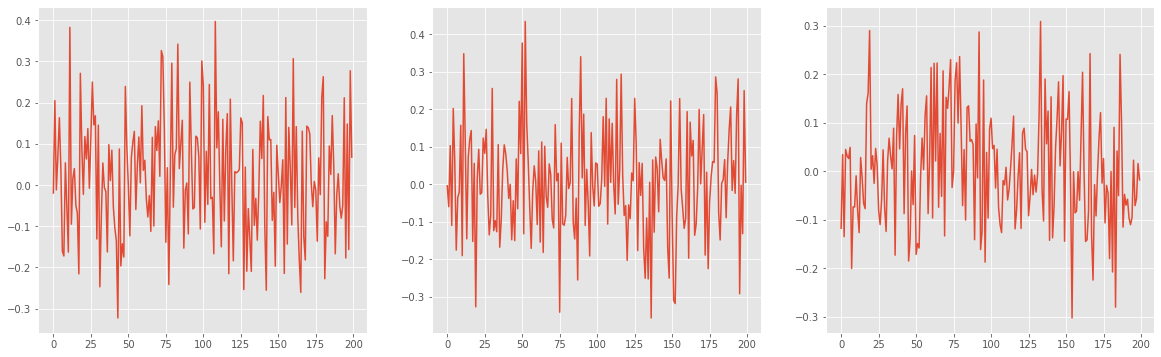

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3,figsize=(20,6))
for i, serie in enumerate(series_output):
  ax[i].plot(serie)

- Nous voyons que les séries générées sont très très semblables..
  - Testons donc avec un vecteur d'entrée nul.

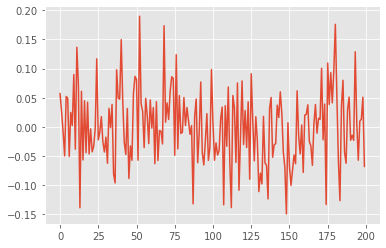

In [ ]:
input_null = np.zeros((1,D))
output_null = generator.predict(input_null)
plt.plot(output_null.flatten());

- Nous voyons donc que le générateur a appris essentiellement du biais, et n'est capable de générer que des variations d'une seule timeseries.

## 6) Faits stylisés (queues grasses)

- On va générer $1000$ séries temporelles de notre générateur, flatten le tout et voir si nous avons des queues grasses pour $|r_t|$

- Nous définissons la fonction permettant de tracer les scales log-log et lin-log d'une distribution cumulative de $|r_t|$

In [ ]:
# Génération de 1000 séries temporelles de notre générateur
inputs = np.random.normal(size=(1000,D))
outputs = generator.predict(inputs)
outputs = outputs.flatten()

In [ ]:
# Fonction pour fonction cumulatrice 1 - ecdf()
def P_sup_r(asset, i, xscale="log", plot_gaussian=False, fix_seed=True, subject="GAN returns prediction"):
  if xscale != "log" and xscale != "linear":
    raise TypeError("xscale doit être en log ou linéaire")
  if plot_gaussian:
    if fix_seed: np.random.seed(77)
    lograndom_g = np.unique(np.sort(np.abs(np.random.normal(loc=asset.mean(),scale=asset.std(),size=asset.shape[0])))) # On rescale sur 100 pour coller avec les rendements
    Ecdf_g = ECDF(lograndom_g)

  # On trie les valeurs absolues distinctes des rendements
  r_abs = np.unique(np.sort(np.abs(asset)))
  y = ECDF(r_abs) # On peut noter que la fonction ECDF trie directement les valeurs

  # On plot le graphique
  ax[i].set(title=r"$P_{>}(|r|)$ for " + subject, xlabel=f"$|r|$ - scale {xscale}", ylabel="$P_{>}(|r|)$", xscale=xscale, yscale="log")
  # On utilise step pour les fonctions en escalier
  ax[i].step(r_abs, 1 - y(r_abs), label="Return", color="red")
  if plot_gaussian: ax[i].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
  ax[i].legend()

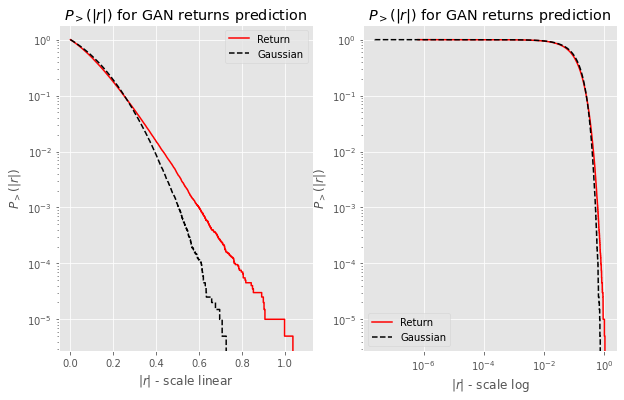

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
P_sup_r(outputs, 0, xscale="linear", plot_gaussian=True)
P_sup_r(outputs, 1, xscale="log", plot_gaussian=True)

- Nous voyons que :
  - Le graphe de gauche (lin-log) ne présente aucune concavité, nous n'avons donc pas de queues grasses.
  - Le graphe de droite (log-log), ou nous sommes censés avoir une droite si nous avions une loi de puissance, montre une forte similitude avec le cas gaussien.

- Nous n'avons donc clairement pas généré de queues grasses.

- Tracons pour les vrais rendements du S&P500 pour en être convaincus :

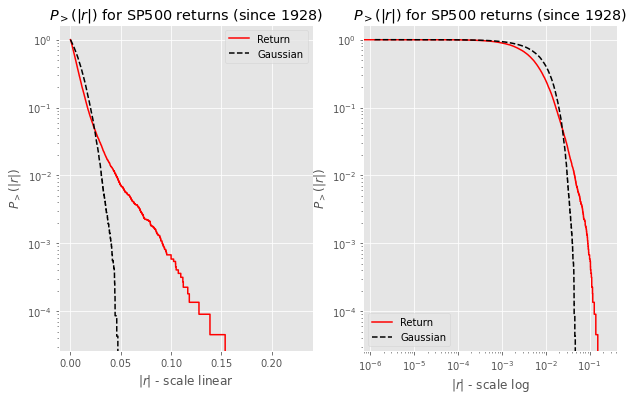

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
P_sup_r(log_r, 0, xscale="linear", plot_gaussian=True, subject="SP500 returns (since 1928)")
P_sup_r(log_r, 1, xscale="log", plot_gaussian=True, subject="SP500 returns (since 1928)")

- Ici nous voyons clairement la concavité pour le du graphe en scale linear-log. Ce fait stylisé doit absolument être reproduit pour nos séries temporelles générées.

### Fait stylisé : cluster de volatilité

- Voyons si la longue mémoire de l'autocorrélation de $|r_t|$ est vérifiée.

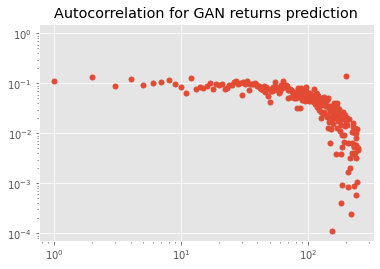

In [ ]:
# Acf de nos outputs
plot_acf(np.abs(outputs),lags=250, alpha=None, use_vlines=False);
plt.xscale("log")
plt.yscale("log")
plt.title("Autocorrelation for GAN returns prediction");

- Nous distinguons difficilement une droite ici, nous allons dire que ce n'est pas optimal. En effet nous cherchions à obtenir une droite signifiant une loi de puissance.

- De même, vérifions pour le SP500.

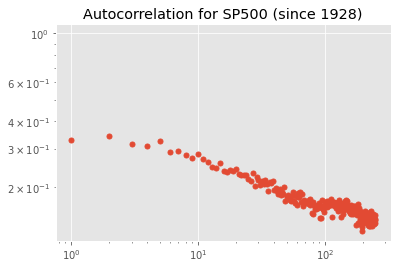

In [ ]:
# Acf de nos outputs
plot_acf(np.abs(log_r),lags=250, alpha=None, use_vlines=False);
plt.xscale("log")
plt.yscale("log")
plt.title("Autocorrelation for SP500 (since 1928)");

Pour le SP500 on distingue plus clairement une droite 

---
# 2 - Réseaux denses moins naïfs

- Désormais, nous allos définir le générateur en ne permettant pas le biais (use_bias=False).

- On garde les mêmes dimensions que la partie précédente pour $D$ et $T$

## 1) Générateur sans biais

In [ ]:
T = 200
D = 10

In [ ]:
generator = Sequential()
generator.add(Dense(units=30, input_dim=D, activation="linear", use_bias=False))
# generator.add(Dropout(rate=0.1))
generator.add(Dense(units=30, activation="linear", use_bias=False))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=30, activation="linear", use_bias=False))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=30, activation="linear", use_bias=False))
generator.add(Dropout(rate=0.1))
generator.add(Dense(units=30, activation="linear", use_bias=False))
# generator.add(Dropout(rate=0.1))
generator.add(Dense(units=30, activation="linear", use_bias=False))
generator.add(Dense(units=T, activation="linear", use_bias=False))

## 2) On réentraine le GAN

- On redéfinit donc les objets discriminateur et GAN, puis on réentraine, le tout de la même manière que la partie précédente.

### Objets et entrainement

In [ ]:
# ----- Discriminateur --------------
discriminator = Sequential()
discriminator.add(Dense(units=20, input_dim=T, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=20, activation="tanh"))
discriminator.add(Dense(units=1, activation="sigmoid"))

# On compile le discriminateur
init_lr = 0.0003
opt_discriminator = Adam(lr = 0.5*init_lr, beta_1 = 0.5)
discriminator.compile(optimizer=opt_gan, loss="binary_crossentropy")
# discriminator.summary()

# ----- Objet GAN ------------------
discriminator.trainable = False
ganInput = Input(shape=(D,)) 
ganOutput = discriminator(generator(ganInput))
gan = Model(ganInput, ganOutput)

# On compile le GAN
opt_gan = Adam(lr = 0.25*init_lr, beta_1=0.5)
gan.compile(optimizer=opt_discriminator, loss="binary_crossentropy")

# ----- Paramètres -----------------
M = batch_size = 32
batch_per_epoch = int(log_r.shape[0] / batch_size)
Mprim = 32 # notre taille de samples de vecteur de bruit pour tromper le discriminateur (on note que dans le tuto M' = M)

# on définit à l'avance y_realGAN qui ne change jamais
y_realGAN = np.concatenate((np.ones(M),np.zeros(M)), axis=0).reshape(-1,1)
# de meme pour notre y_fake
y_fake = np.ones(Mprim).reshape(-1,1)

In [ ]:
X_real = np.zeros((M,T))

#----------- ENTRAINEMENT DU GAN -------------- 
for i in tqdm(range(batch_per_epoch)):

  # Notre matrice X_real contient bcp de superpositions, c'est le même format que l'input d'un LSTM typiquement
  for j in range(M):
    X_real[j,:] = log_r[(j+i):(j+i)+T].values 

  # nos features aléatoires eta
  eta = np.random.normal(size=(M,D))

  # X_gan prédite par le générateur
  X_GAN = generator.predict(eta)

  # on concatene X_real et X_gan
  X_realGAN = np.concatenate((X_real, X_GAN), axis=0)

  # on shuffle les lignes pour que ca soit fait aléatoirement -> le réseau ne va pas apprendre de l'ordre
  (X_realGAN_s, y_realGAN_s) = shuffle(X_realGAN, y_realGAN)

  #----- Entrainer le discriminateur ------ 
  disc_loss = discriminator.train_on_batch(X_realGAN, y_realGAN) # n'entraine que les poids du discriminateur

  #----- Entrainer le GAN ------ 
  # on créé notre matrice de bruit pour tromper le discriminateur
  eta = np.random.normal(size=(Mprim,D))
  # X_fake = generator.predict(eta) # on note que dans le tuto il ne prédit pas et entraine directement avec les eta
  gan_loss = gan.train_on_batch(eta, y_fake) # n'entraine que les poids du générateur

  print(disc_loss, gan_loss)

### Tracé des séries obtenues par le générateur

In [ ]:
# Nos 3 vecteurs d'entrées
inputs = np.random.normal(size=(3,D))

# On demande au discriminateur de prédire si ce sont des séries temporelles
probas = gan.predict(inputs)
probas

array([[0.49139884],
       [0.5145775 ],
       [0.4771967 ]], dtype=float32)

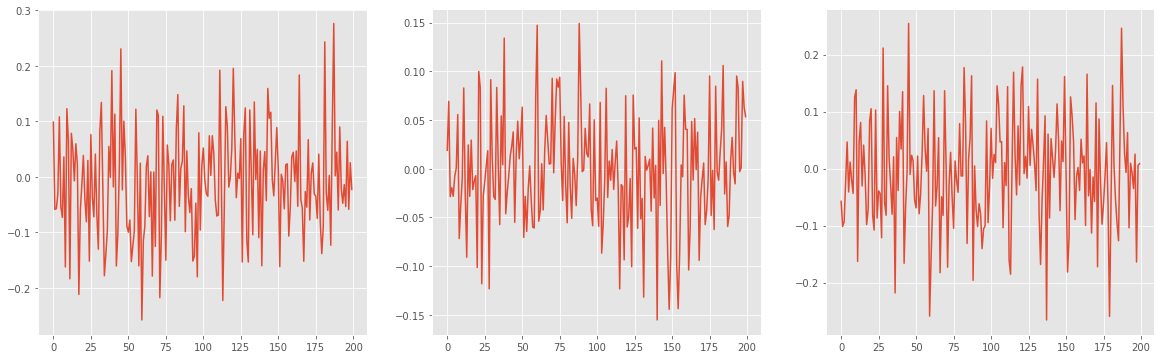

In [ ]:
# On génère nos séries avec le générateur
series_output = generator.predict(inputs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,inputs.shape[0],figsize=(20,6))
for i, serie in enumerate(series_output):
  ax[i].plot(serie)

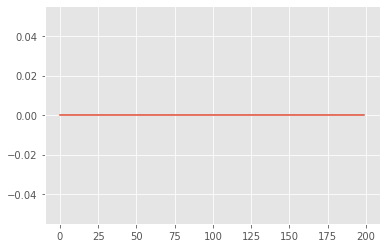

In [ ]:
input_null = np.zeros((1,D))
output_null = generator.predict(input_null)
plt.plot(output_null.flatten());

- On vérifie ici que le générateur n'a pas appris du biais, en effet pour un vecteur d'entrée nul le générateur ne génère aucune série temporelles, ce qui est rassurant. 

### Faits stylisés

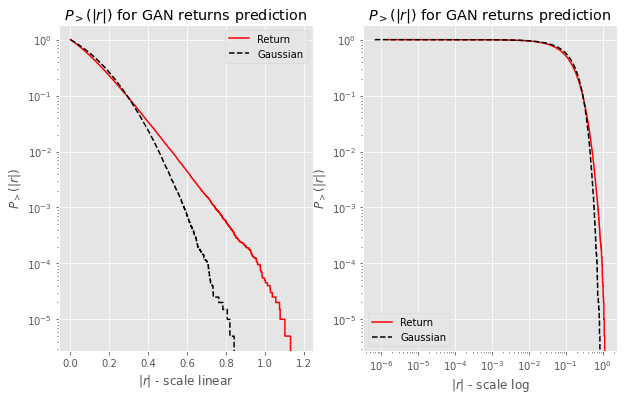

In [ ]:
# Génération de 1000 séries temporelles de notre générateur
inputs = np.random.normal(size=(1000,D))
outputs = generator.predict(inputs)
outputs = outputs.flatten()

fig, ax = plt.subplots(1,2, figsize=(10,6))
P_sup_r(outputs, 0, xscale="linear", plot_gaussian=True)
P_sup_r(outputs, 1, xscale="log", plot_gaussian=True)

- Nous voyons clairement que la concavité est bien plus marquée, mais ce n'est pas non plus optimal.


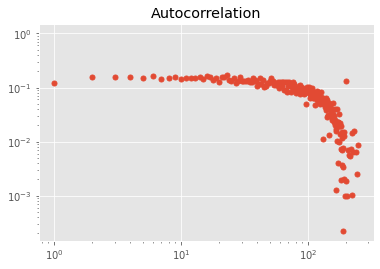

In [ ]:
# Acf de nos outputs
plot_acf(np.abs(outputs),lags=250, alpha=None, use_vlines=False);
plt.xscale("log")
plt.yscale("log")

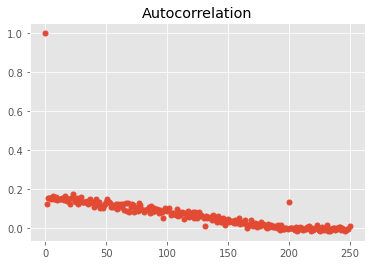

In [ ]:
# Acf de nos outputs
plot_acf(np.abs(outputs),lags=250, alpha=None, use_vlines=False);
plt.xscale("linear")
plt.yscale("linear")

- Cette fois, le fait stylisé propre à l'autocorrélation est bien plus respecté, nous pouvons clairement voir une ligne droite, très plate ce qui signifierait que l'exposant de la loi de puissance est petit.

## 3) Méthode possible pour obtenir des queues grasses

- Nous pouvons utiliser la méthode de Wiese : 
  - Transformer les rendements en données gaussienes, 
  - Faire apprendre cela au GAN afin que le générateur nous génère des données gaussienes
  - Effectuer la transformée inverse pour avoir les rendements avec des queues grasses. 